# Tests JSA calculation class

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import savemat
from topdc_calc import topdc_calc
from matplotlib.ticker import FormatStrFormatter

#### Import the dispersion parameters

In [2]:
#Dispersion import 

dispdata=np.load('disp_data.npy',allow_pickle=True).item()
omf=dispdata['omf']
triplet_neff=dispdata['triplet_neff']
omp=dispdata['omp']
pump_neff=dispdata['pump_neff']
wp_cutoff=9.8  #Pump mode cutoff frequency in 10^14 rad/s

test=topdc_calc(omf,triplet_neff,omp,pump_neff,wp_cutoff)

In [3]:
# Declaration of variables

c0=3 # Velocity of light in vacuum in um/(1e-14 s)
L=300000 # Waveguide length in um ->10000 um=1 cm

wf0=test.w_pm(13)   # Triplet phase-matching frequency in 10^14 rad/s (The input parameter 13  is the initial guess for the triplet central frequency--> You can check this by plotting the dispersion of the pump and triplet modes) 
wp0=3*wf0   # Pump phase-matching frequency in 10^14 rad/s 

In [4]:
print('Triplet central frequency: '+str(wf0)+' [x10^14 rad/s]')
print('Triplet central wavelength: '+str(2*np.pi*c0/wf0)+' um')
print('Pump central frequency: '+str(wp0)+' [x10^14 rad/s]')
print('Pump central wavelength: '+str(2*np.pi*c0/wp0)+' um')

Triplet central frequency: 13.696149605647763 [x10^14 rad/s]
Triplet central wavelength: 1.3762667949951373 um
Pump central frequency: 41.08844881694329 [x10^14 rad/s]
Pump central wavelength: 0.45875559833171237 um


In [5]:
#Evaluation of the JSA

# Spectral resolution
sigmap=test.pm_bw(L,13) #Approximate HWHM of the phase-matching function, measured in terms of the sinc's main lobe width
delw=sigmap/60 # The spectral resolution is defined such that a minimum of 60 discrete points are sampled within each frequency vector over the bandwidth of the phase-matching function, regardless of the specific width of the evaluation function.

#Spectral window
domg=8*sigmap # We set the half-width of the frequency window wide enough to sample correctly both the jsa and reduced density matrix
omf1=np.arange(wf0-domg,wf0+domg,delw) # Frequency evaluation vector centered at the photon triplet phase-matching frequency with units 10^14 rad/s
# omf1=np.arange(11.5,15,delw)
print(omf1.size) # Note: Always check the frequency vector size, because later we are going to build a 3D grid with it, which greatly affects the memory usage. 

print(test.jsa(wf0,wf0,wf0,L,wp0,sigmap)) # Checking that the jsa is 1 at the triplet phase-matching frequency


960
1.0


#### CW Pump: 

If we consider a continuous wave (CW) pump, the pump envelope function is equivalent to  $\alpha \left(\omega_1,\omega_2,\omega_3\right)= \delta \left(\omega_1+\omega_2+\omega_3-\omega_P\right)$. 
In this case, the JSA is nonzero only on the plane $\omega_1+\omega_2+\omega_3=\omega_P$.

In [6]:
w1v,w2v= np.meshgrid(omf1, omf1, indexing='xy') # We generate an evaluation grid using w1 and w2
w3v=wp0-w1v-w2v # We restrict to the frequencies w3=wp0-w1-w2 for a CW pump
jsa_cw=test.jsa(w1v,w2v,w3v,L,wp0,0.0001)  # Evaluation of the jsa calculation function
jsa_cw_proj=abs(jsa_cw)**2

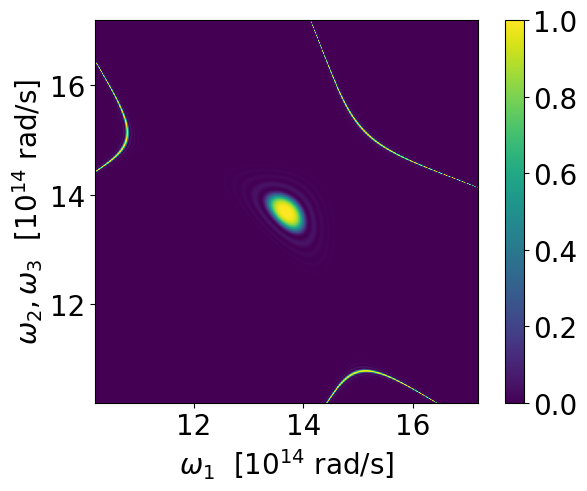

In [7]:
font={'size':20}
plt.rc('font',**font)

fig1, axs1 = plt.subplots(1, 1, sharex=True, sharey=True, constrained_layout=True)

c1=axs1.pcolor(omf1,omf1, jsa_cw_proj/np.max(jsa_cw_proj), rasterized=True)

axs1.set_xlabel(r'$\omega_{1}$  [$10^{14} $ rad/s]')
axs1.set_ylabel(r'$\omega_{2}, \omega_{3}$  [$10^{14} $ rad/s]')
axs1.set_box_aspect(1)
axs1.yaxis.set_major_formatter(FormatStrFormatter('%g'))
fig1.colorbar(c1)
fig1.set_edgecolor('none')
plt.gca().set_aspect('equal')

plt.show()

#### Pump bandwidth matching the phase-matching bandwidth: Unfiltered JSA

In [8]:
jsa_data=test.jsa(omf1[:,None,None],omf1[None,:,None],omf1[None,None,:],L,wp0,sigmap)  # Evaluation of the jsa calculation function
jsa_proj=np.sum(np.square(np.abs(jsa_data)), axis=0)
njsa_proj=jsa_proj/np.nanmax(jsa_proj)

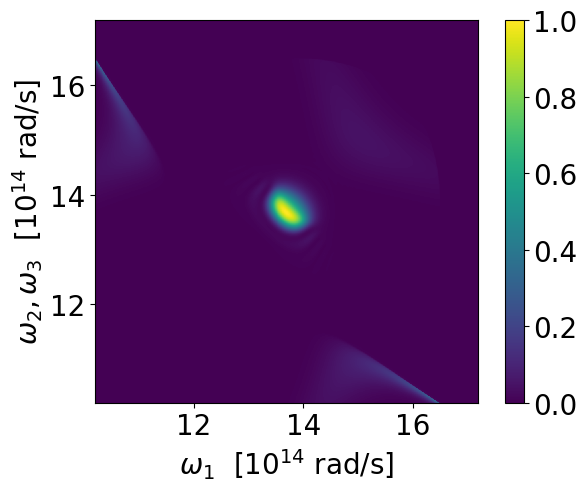

In [9]:
font={'size':20}
plt.rc('font',**font)

fig2, axs2 = plt.subplots(1, 1, sharex=True, sharey=True, constrained_layout=True)

c2=axs2.pcolor(omf1,omf1, njsa_proj, rasterized=True)

axs2.set_xlabel(r'$\omega_{1}$  [$10^{14} $ rad/s]')
axs2.set_ylabel(r'$\omega_{2}, \omega_{3}$  [$10^{14} $ rad/s]')
axs2.set_box_aspect(1)
axs2.yaxis.set_major_formatter(FormatStrFormatter('%g'))

fig2.colorbar(c2)
fig2.set_edgecolor('none')
plt.gca().set_aspect('equal')

plt.show()

#### Pump bandwidth matching the phase-matching bandwidth: Filtered JSA

We are going to filter outside the frequencies $[11.5,15]\times~10^{14}$ rad/s.

In [10]:
wlow=11.5
whigh=15
jsaf=test.jsa_filter(omf1[:,None,None],omf1[None,:,None],omf1[None,None,:],L,wp0,sigmap,wlow,whigh)  # Evaluation of the jsa calculation function
jsaf_proj=np.sum(np.square(np.abs(jsaf)), axis=0)
njsaf_proj=jsaf_proj/np.nanmax(jsaf_proj)

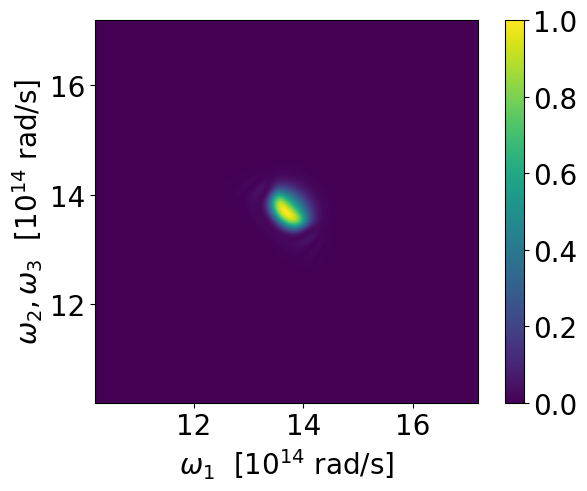

In [11]:
font={'size':20}
plt.rc('font',**font)

fig3, axs3 = plt.subplots(1, 1, sharex=True, sharey=True, constrained_layout=True)

c3=axs3.pcolor(omf1,omf1, njsaf_proj, rasterized=True)

axs3.set_xlabel(r'$\omega_{1}$  [$10^{14} $ rad/s]')
axs3.set_ylabel(r'$\omega_{2}, \omega_{3}$  [$10^{14} $ rad/s]')
axs3.set_box_aspect(1)

fig3.colorbar(c3)
fig3.set_edgecolor('none')
plt.gca().set_aspect('equal')

plt.show()

#### Data export

In [12]:
jsa_cw_dict={
    "tag":"JSI_unfiltered_CW_pump",
    "omf":omf1,
    "jsi_proj":jsa_cw_proj
}

# savemat("Data_export/JSI_unfiltered_CW_pump.mat",jsa_cw_dict)

In [13]:
jsa_no_filter_fit_pump_dict={
    "tag":"JSI_unfiltered_fitted_pump",
    "omf":omf1,
    "jsi_proj":jsa_proj
}

# savemat("Data_export/JSI_unfiltered_fitted_pump.mat",jsa_no_filter_fit_pump_dict)

In [14]:
jsa_filter_fit_pump_dict={
    "tag":"JSI_filtered_fitted_pump",
    "omf":omf1,
    "jsi_proj":jsaf_proj
}

# savemat("Data_export/JSI_filtered_fitted_pump.mat",jsa_filter_fit_pump_dict)